In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import mediapipe as mp
from pathlib import Path
from time import time
rng = np.random.default_rng()

<h3>Functions</h3>

get_hand_from_file(filepath)
get_hand_from_image(image)
    return: pair (exit_code, img_out) 
    exit_code is 1 on success and 0 on failure. 
    img_out is a cropping of the input image around the detected hand on success, the input image itself on failure.
    
rescale_square(image, size)
    return: the given image, up- or down-sampled to a square of side length <i>size</i>.
    assumes <i>image</i> has the shape of a square. if not, use square_and_rescale().
    if <i>image</i> already has the specified size, it's returned unaltered
    
square_and_rescale(image, size)
    return: a square image of side length <i>size</i>, containing <i>image</i> up- or down-sampled so that its longest side has the specified length, padded with noise or zeros if <i>image</i> is not already a square.
    the padding is randomly added above or below, or left or right, of the scaled image, as appropriate.
    will try to convert the given image's datatype to uint8, or if <i>datatype='float32'</i> is specified to float32.
    noise options are <i>fill_type=</i> 'uniform', 'gauss', or 'int' (or anything else for zeros). an exception will be raised if the random number type (float32 for 'uniform' and 'gauss', uint8 for 'int', anything for zeros) does not agree with the specified datatype for the image.

In [234]:
def clamp(x, y, sizes):
    x = max(0, min(x, sizes[1]))
    y = max(0, min(y, sizes[0]))
    return x,y

# a 'rectangle corners' is a pair (min_corner, max_corner), where min_corner = (x_min, y_min) is the vertex with
# smallest co-ordinates and max_corner = (x_max, y_max) is the vertex with the largest co-ordinates
def get_bounding_box_corners(landmark_values, size, pad_fraction=0.2, pad_constant=5):
    coord_list_x = []
    coord_list_y = []
    y_size, x_size = size
    for landmark in landmark_values:
        coord_list_x.append(int(landmark.x * x_size))
        coord_list_y.append(int(landmark.y * y_size))
    x_min, x_max, y_min, y_max = min(coord_list_x), max(coord_list_x), min(coord_list_y), max(coord_list_y)
    x_pad, y_pad = pad_constant+int((x_max - x_min)*pad_fraction), pad_constant+int((y_max-y_min)*pad_fraction)
    min_corner = clamp(x_min-x_pad, y_min-y_pad, size)
    max_corner = clamp(x_max+x_pad, y_max+y_pad, size)
    return (min_corner, max_corner)

def get_rectangle(corners, image):
    return image[corners[0][1]:corners[1][1], corners[0][0]:corners[1][0]]

def get_bounding_box(landmark_values, image, **kwargs):
    min_corner, max_corner = get_bounding_box_corners(landmark_values, image.shape[0:2], **kwargs)
    return get_rectangle(corners, image)

def get_rectangle_join_corners(rectangle_list):
    min_corner = (np.inf, np.inf)
    max_corner = (0,0)
    for rectangle in rectangle_list:
        min_corner = (min(min_corner[0], rectangle[0][0]), min(min_corner[1], rectangle[0][1]))
        max_corner = (max(max_corner[0], rectangle[1][0]), max(max_corner[1], rectangle[1][1]))
    return (min_corner, max_corner)

def get_rectangle_meet_corners(rectangle_list):
    min_corner = (0,0)
    max_corner = (np.inf, np.inf)
    for rectangle in rectangle_list:
        min_corner = (max(min_corner[0], rectangle[0][0]), max(min_corner[1], rectangle[0][1]))
        max_corner = (min(max_corner[0], rectangle[1][0]), min(max_corner[1], rectangle[1][1]))
    return (min_corner, max_corner)

def get_rectangle_join(rectangle_list, image):
    corners = get_rectangle_join_corners(rectangle_list)
    return get_rectangle(corners, image)

def get_prism_join(rectangle_list, image_array):
    corners = get_rectangle_join_corners(rectangle_list)
    return image_array[:, corners[0][1]:corners[1][1], corners[0][0]:corners[1][0]]

In [235]:
# functions to normalise image shape and size

def rescale_square(image, size, 
                   upscale = cv.INTER_CUBIC,    # or cv.INTER_LINEAR, or others
                   downscale = cv.INTER_AREA,   # or cv.INTER_NEAREST, or others
                   blur = 'bilateral',          # or 'gauss' or 'none'
                   ksize = (5,5), sigmaX = 0,                  # defaults for Gaussian blur
                   d = 9, sigmaColor = 75, sigmaSpace = 75,    # detaults for bilateral blur
                   **kwargs):
    assert image.shape[0] == image.shape[1]
    
    if image.shape[0] > size:
        return cv.resize(image, (size,size), interpolation=downscale)
    elif image.shape[0] < size:
        ret = cv.resize(image, (size, size), interpolation = upscale)
        if blur.lower() == 'gauss':            
            return cv.GaussianBlur(ret,
                                   kwargs.pop('ksize', ksize),
                                   kwargs.pop('sigmaX', sigmaX),
                                   **kwargs)
        elif blur.lower() == 'bilateral':
            return cv.bilateralFilter(ret,
                                      kwargs.pop('d', d),
                                      kwargs.pop('sigmaColor',sigmaColor),
                                      kwargs.pop('sigmaSpace',sigmaSpace),
                                      **kwargs)
        return ret
    return image

def square_and_rescale(image, target_size, fill_type = 'int',datatype='uint8', **kwargs):
    # the OpenCV functions require either float32 or uint8
    imtype = image.dtype
    datatype = np.dtype(datatype)
    if imtype.kind == 'f':
        if (datatype.kind == 'f') and (datatype != imtype):
            image = np.float32(image)
        elif datatype.kind == 'u':
            image = np.uint8(image*255)
    elif imtype.kind == 'u':
        if (datatype.kind == 'u') and (datatype != imtype):
            image = np.uint8(image)
        elif datatype.kind == 'f':
            image = np.float32(image/255)
    imtype = image.dtype
            
    if len(image.shape) < 3:
        image = np.expand_dims(image, 2)
    y_size, x_size, channels = image.shape
    if y_size * x_size == 1:
        return np.zeros((target_size, target_size, channels), dtype=np.uint8)
    fill_size = 0
    if y_size > x_size:          
        fill_size = (y_size, y_size-x_size, channels)
    elif x_size > y_size:
        fill_size = (x_size-y_size, x_size, channels)
    if fill_size:
        if fill_type.lower() == 'uniform' and imtype.kind == 'f':
            fill = rng.random(size=fill_size, dtype=imtype)
        elif fill_type.lower() == 'gauss' and imtype.kind == 'f':
            fill = np.positive(rng.standard_normal(size=fill_size, dtype=imtype))
        elif fill_type.lower() == 'int' and imtype.kind == 'u':
            fill = rng.integers(0, 256, size=fill_size, dtype=imtype)
        else:
            fill = np.zeros(fill_size, dtype=imtype)
    coin_flip = rng.integers(0,1, endpoint=True)
    if y_size > x_size:
        if coin_flip:
            image = np.hstack([image, fill])
        else:
            image = np.hstack([fill, image])
    elif x_size > y_size:       
        if coin_flip:
            image = np.vstack([image, fill])
        else:
            image = np.vstack([fill, image])
    # curiously some of the cv resize/blur functions can escape their proper ranges under some circumstances, so we clamp
    max_val = {'float32':1, 'uint8':255}[str(image.dtype)]
    return np.clip(rescale_square(image, target_size, **kwargs), 0, max_val)
    

In [67]:
# functions to normalise hand geometry

# put the hand landmark data in non-google-mystery-storage-object
def copy_landmarks_to_array(landmarks, array):
    for j in range(0,21):
        array[j][0] = landmarks._values[j].x
        array[j][1] = landmarks._values[j].y
        array[j][2] = landmarks._values[j].z
        
def get_handedness(hands_results):
    return hands_results.multi_handedness[0].classification._values[0].label
        
# transforms left hands into mirrored right hand position
# (curiously, mpHands exhibited chirality in some of our cropped images!)
def transform_handedness(array):
    array[:,0] = -array[:,0]+1
    return array

def plot_hands(hand1, hand2=None, figsize = (10,10)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(projection='3d')
    ax.scatter(hand1[:,0], hand1[:,1], hand1[:,2], marker='o')
    try:
        ax.scatter(hand2[:,0], hand2[:,1], hand2[:,2], marker='^')
    except:
        print(Excepted)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show()

# currently the normalised hands have the wrist at the origin, the triangle it makes with the knuckles of the 
# index and middle in the plane z = 0, and the x-axis bisecting that triangle
# in particular, this does not account for variable hand geometry
def normalise_hand_position(arrayIn):
    arrayOut = arrayIn - np.array([[arrayIn[0,0], arrayIn[0,1], arrayIn[0,2]]]*21)
    if list(arrayOut[5,:]) == [0,0,0] or list(arrayOut[9,:]) == [0,0,0]:
        return arrayIn
    u1 = arrayOut[5,:] / np.linalg.norm(arrayOut[5,:])
    u3 = np.cross(u1, arrayOut[9,:])
    if u3[2] < 0:
        #u3 = -u3
        arrayOut[:,0] *= -1
        u3 = np.cross(u1, arrayOut[9,:])
    u3 = u3 / np.linalg.norm(u3)
    u2 = np.cross(u3, u1)
    rotM = np.linalg.inv([u1, u2, u3])
    return arrayOut.dot(rotM)
    
# moves a hand so its landmarks' centroid is at the origin. in tests kNN worked much worse this way.
def center_hand(array):
    temp = np.ones(array.shape[0])
    center = array.mean(axis=0)
    array[:,0] -= center[0] * temp
    array[:,1] -= center[1] * temp
    array[:,2] -= center[2] * temp

 Landmark atlas: see https://google.github.io/mediapipe/solutions/hands
 
 The landmarks start at the wrist and move to the end of each finger in turn:
 
 wrist: 0
 
 thumb: 1, 2, 3, 4
 
 index: 5, 6, 7, 8
 
 middle: 9, 10, 11, 12
 
 ring: 13, 14, 15, 16
 
 small: 17, 18, 19, 20
 
 So for example the palm is represented by the marks 0, 5, 9, 13, 17.

In [5]:
# need to finish cleaning this up
# scripts for getting geometry from existing image datasets/splits

def model_hand_from_dataset(img_dataset, normalise = True):
    hands_img = np.zeros((len(img_dataset),21,3))
    hands_wrl = np.zeros((len(img_dataset),21,3))
    success_list=[]    
    for j,image in enumerate(img_dataset):
        results = hands.process(image)
        if not results.multi_hand_world_landmarks:        
            results = hands.process(cv.flip(image,1))
        if results.multi_hand_world_landmarks:       
            copy_landmarks_to_array(results.multi_hand_landmarks[0].landmark, hands_img[j])
            copy_landmarks_to_array(results.multi_hand_world_landmarks[0].landmark,hands_wrl[j])
            if normalise:
                hands_obt[j] = normalise_hand_position(hands_obt[j])
            success_list.append(j)
    return hands_img, hands_wrl, success_list

In [ ]:
# geom_full has the same length as images, with a list of co-ordinates in the indices the detector found them, zeros elsewhere
# indices has the positions where geom_full is not zero
geom_img = {}
geom_wrl = {}
indices = {}
for key in splits:
    geom_img[key], geom_wrl[key], indices[key] = model_hand_from_dataset(images[key])
    
# geom has the hand co-ordinates with the zero entries removed
# geom_lbl has the corresponding labels in an array of the same size
geom = {}
geom_lbl = {}
for key in splits:
    geom[key] = geom_full[key][indices[key]]
    geom_lbl[key] = labels[key][indices[key]]
    print(key, geom_lbl[key].shape, labels[key].shape) 

In [ ]:
for key in splits:
    np.save("datasets/" + key + "_geom_full.npy", geom_full[key])
    np.save("datasets/" + key + "_geom.npy", geom[key])
    np.save("datasets/" + key + "_geom_lbl.npy", geom_lbl[key])
    np.save("datasets/bak/" + key + "_geom_indices.npy", indices)

Tests/examples for square_and_rescale()

(91, 79)


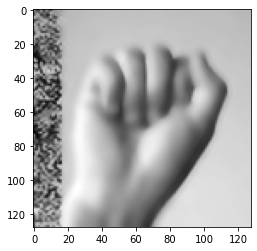

In [575]:
grey_img=cv.imread("temp/A9.jpg",flags=0)
print(grey_img.shape)
plt.imshow(square_and_rescale(grey_img,128, fill_type='int'), 'gray')
plt.show()

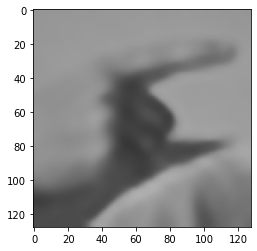

In [577]:
img = cv.imread("temp/0.png")
plt.imshow(square_and_rescale(img, 128))
plt.show()

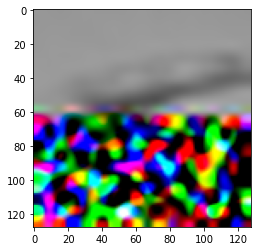

In [587]:
crop = np.float32(img[0:10,5:25])/255
newimg = square_and_rescale(crop, 128, fill_type='gauss', blur='gauss')
plt.imshow(newimg)
plt.show()

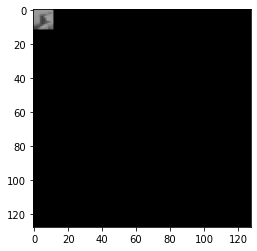

In [585]:
bigimg = np.zeros((300,300,3), dtype=np.uint8)
bigimg[0:28,0:28] = img

newimg = square_and_rescale(bigimg, 128)
plt.imshow(newimg)

In [ ]:
# a dict of all the keys and values that appear (except 'subgroup') in datasets I've tagged
# this isn't used for anything yet (maybe never will)
keywords={'dataset':['cap','dis','grass','mav1','mav2','urgarg'],'subgroup':['none'], 'colour':['greyscale','rbg','bgr'], 
          'crop':['close','none'], 'size':['small','large','128'], 'shape':['square', 'rectangle'],
         'fill':['gauss','uniform','int','zeros']}

In [5]:
# in collecting our datasets together some will use different expressions for the same sign, for example, 'a' and 'A'.
# Here we settle which expression we will use.
def standardise_sign(sign):
    try:
        return sign.lower()
    except:
        return sign

splits = ['train','val','hold']
# train is the training data, val is the model cross-validation data, hold is the final check data

In [6]:
dis_ord = rng.permutation([1,2,3,4,5])
grs_ord = rng.permutation([1,2,3,4])    
urg_ord = rng.permutation([3,4,5,6,7,9,10])
print(dis_ord, grs_ord, urg_ord)

[2 3 1 4 5] [3 4 2 1] [ 7 10  4  9  6  3  5]


In [7]:
# for each dataset, determine which elements go into which splits

# these datasets are composed of subgroups each of which must go into only one split
dis_ord = [2,3,1,4,5]
grs_ord = [3,4,2,1]
urg_ord = [7,10,4,9,6,3,5]    

dis_split = (3,4,5) # cumulative sum of (3,1,1)
grs_split = (2,3,4) #                   (2,1,1)
urg_split = (5,6,7) #                   (5,1,1)

dis_dict = {'hand'+ str(j) : 0 for j in dis_ord[0:dis_split[0]]}
dis_dict.update( {'hand'+ str(j) : 1 for j in dis_ord[dis_split[0]:dis_split[1]] } )
dis_dict.update( {'hand'+ str(j) : 2 for j in dis_ord[dis_split[1]:] } )

grs_dict = {'video'+str(j) : 0 for j in grs_ord[0:grs_split[0]]}
grs_dict.update( {'video'+ str(j) : 1 for j in grs_ord[grs_split[0]:grs_split[1]]})
grs_dict.update( {'video'+ str(j) : 2 for j in grs_ord[grs_split[1]:]})

urg_dict = {'user_'+str(j) : 0 for j in urg_ord[0:urg_split[0]]}
urg_dict.update( {'user_'+ str(j) : 1 for j in urg_ord[urg_split[0]:urg_split[1]] } )
urg_dict.update( {'user_'+ str(j) : 2 for j in urg_ord[urg_split[1]:]})

# returns name of a list split. 'bad_lbl' is the error return code, but currently that'll just raise an exception
def assignment(dataset, subgroup, index=0):
    if dataset == 'cap':
        if subgroup == 'model1':
            return 0
        elif subgroup == 'model2':
            try:
                if index % 4 != 0:
                    return 1
                else:
                    return 2
            except:
                return 'bad_lbl'
        else:
            return 'bad_lbl'
        
    if dataset == 'dis':
        return dis_dict.get(subgroup, 'bad_lbl')       
    if dataset == 'grass':
        return grs_dict.get(subgroup, 'bad_lbl')
    if dataset == 'urgarg':
        return urg_dict.get(subgroup, 'bad_lbl')
    
    # datasets without repeated models
    if dataset in ['mav1', 'mav2', 'lee']:
        try:
            if index % 5 != 0:
                return 0
            if index % 15 != 0:
                return 1
            if index % 15 == 0:
                return 2
        except:
            return 'bad_lbl' 

    # single-model datasets unsuitable to be split
    if dataset in ['bredun']:
        return 0
    return 'bad_lbl'          

In [8]:
# script for loading datasets saved as numpy arrays. the image filenames should be prefixed with img, the labels with lbl.
path = "datasets/bak/"

imagesets = []
labelsets = []
for file in Path(path).iterdir():
    if not file.is_file():
        continue
    if file.name[0:3] == 'img':
        imagesets.append(np.load(str(file), allow_pickle=True))
    elif file.name[0:3] == 'lbl':
        labelsets.append(np.load(str(file), allow_pickle=True))

In [9]:
hands_static = mp.solutions.hands.Hands(static_image_mode=True,
                                        max_num_hands=1,
                                        min_detection_confidence=0.5)

def get_hand_from_image(image, colour = 'rgb', pad_fraction = 0.2, pad_constant = 5):
    if colour.lower() == 'bgr':
        results = hands_static.process(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    else:
        results = hands_static.process(image)
    if not results.multi_hand_landmarks:
        return (0, [image], [np.zeros((21,3), dtype=np.float32)], [np.zeros((21,3), dtype=np.float32)])
    boxes = {}
    marks_img = {} 
    marks_wrl = {}
    for hand in range(len(results.multi_hand_landmarks)):
        # mp.Hands does left/right determination but it's not good enough
        #hand = results.multi_handedness[index].classification[0].label.lower()
        
        # mp.Hands generates two landmark sets, differing essentially in how they treat the depth of landmarks
        # the 'image position' estimates distance from the camera, I guess using some image proc methods
        # the 'world position' appears to estimate real-world angles, maybe using some ML method
        # MediaPipe internally calls the latter 'normalised landmarks' but the difference is not a simple transformation
        # in basic tests (like kNN), world marks performed slightly better
        marks = results.multi_hand_landmarks[hand].landmark
        boxes[hand] =  cv.flip(get_bounding_box(marks._values, image, 
                            pad_fraction=pad_fraction, pad_constant=pad_constant), 1)       
        marks_img[hand] = np.zeros((21,3), dtype=np.float32)        
        copy_landmarks_to_array(marks, marks_img[hand])
        marks_img[hand] = normalise_hand_position(marks_img[hand])
        
        marks = results.multi_hand_world_landmarks[hand].landmark
        marks_wrl[hand] = np.zeros((21,3), dtype=np.float32)
        copy_landmarks_to_array(marks, marks_wrl[hand])
        marks_wrl[hand] = normalise_hand_position(marks_wrl[hand])
    return (1, boxes, marks_img, marks_wrl)

def get_hand_from_file(filepath, **kwargs):
    image = cv.flip(cv.imread(filepath), 1)
    return get_hand_from_image(image, colour='bgr', **kwargs)

In [10]:
# script for standardising images from datasets and splitting them among sets train, val, hold
# at the moment this assumes each image has a single hand to get
generate_geometry = True
target_size = 224
fill_type = 'int'
blur_type = 'bilateral'

images = {'bad_lbl':[]}
geom_img ={'bad_lbl':[]}
geom_wrl = {'bad_lbl':[]}
labels = {'bad_lbl':[]}
images.update({key:[] for key in splits})
geom_img.update({key:[] for key in splits})
geom_wrl.update({key:[] for key in splits})
labels.update({key:[] for key in splits})

target_shape = 'square'
justnow = time()
filecount = 0
geom_fail_count = 0
max_sign_length = 0
for setindex, imgset in enumerate(imagesets):
    for imgindex, img in enumerate(imgset):
        lbl = labelsets[setindex][imgindex]
        if lbl['colour'].lower() == 'bgr':
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            lbl.update({'colour':'rgb'})   
            
        if generate_geometry or lbl.get('crop', False) != 'close':
            ret, box, mark_img, mark_wrl = get_hand_from_image(img)
            if ret:
                lbl.update({'crop':'close'})
        #else:
        #    lbl.update({'shape':'square','size':str(target_size),'blur':blur_type})
            img = square_and_rescale(box[0],
                                target_size,
                                fill_type = fill_type,
                                blur = blur_type)
        else:
            img = square_and_rescale(img, target_size, fill_type=fill_type, blur = blur_type)
        lbl.update({'shape':'square','size':str(target_size), 'fill':fill_type, 'blur':blur_type})
        assign = assignment(lbl.get('dataset', None), lbl.get('subgroup', None), imgindex)
        if assign == 'bad_lbl':
            print('Bad label generated: ', setindex, imgindex, lbl)
        else:
            assign = splits[assign]
        sign = standardise_sign(lbl['sign'])
        max_sign_length = max(len(sign), max_sign_length)
        lbl.update({'sign': sign})
        try:
            images[assign].append(img)
            if generate_geometry:
                geom_img[assign].append(mark_img[0])
                geom_wrl[assign].append(mark_wrl[0])
            labels[assign].append(lbl)
        except:
            print("Exc:", setindex, imgindex, assign)
        filecount += 1
now = time()
print('Elapsed time: ', now-justnow)
print('FPS: ', filecount/(now-justnow))

Elapsed time:  1623.3610427379608
FPS:  22.207629141571847


In [11]:
sign_dtype = '<U' + str(max_sign_length)
sign_labels = {key: np.zeros((len(images[key])), dtype = sign_dtype) for key in splits}

for key in splits:
    for j, lbl in enumerate(labels[key]):
        sign_labels[key][j] = labels[key][j]['sign']
    print(len(sign_labels[key]))

26559
5793
3699


In [12]:
label_set = np.unique(sign_labels[splits[0]])
label_count = len(label_set)
for key in splits:
    assert label_count == len(np.unique(sign_labels[key]))

In [13]:
# replaces sign string labels with id numbers
encoder = {label_set[ind]:ind for ind in range(label_count)}
print(encoder)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'a': 10, 'b': 11, 'bye': 12, 'c': 13, 'd': 14, 'del': 15, 'e': 16, 'f': 17, 'g': 18, 'good': 19, 'good morning': 20, 'h': 21, 'hello': 22, 'i': 23, 'j': 24, 'k': 25, 'l': 26, 'little bit': 27, 'm': 28, 'n': 29, 'no': 30, 'null': 31, 'o': 32, 'p': 33, 'pardon': 34, 'please': 35, 'project': 36, 'q': 37, 'r': 38, 's': 39, 'space': 40, 't': 41, 'u': 42, 'v': 43, 'w': 44, 'whats up': 45, 'x': 46, 'y': 47, 'yes': 48, 'z': 49}


In [14]:
for key in splits:
    for j, lbl in enumerate(labels[key]):
        sign_labels[key][j] = encoder[sign_labels[key][j]]
    sign_labels[key] = np.uint8(sign_labels[key])

In [25]:
path = "datasets/"
for key in splits:
    np.save(path + key + "_img_64.npy", images[key])
    np.save(path + key + "_geom_img.npy", geom_img[key])
    np.save(path + key + "_geom_wrl.npy", geom_wrl[key])
    np.save(path + key + "_lbl.npy", sign_labels[key])

In [15]:
path = "datasets/"
for key in splits:
    np.save(path + key + "_img_224.npy", images[key])
    np.save(path + key + "_geom_img.npy", geom_img[key])
    np.save(path + key + "_geom_wrl.npy", geom_wrl[key])
    np.save(path + key + "_lbl.npy", sign_labels[key])

<h3>Input channel expansion</h3>

Shorten-Khoshgoftaar venture that "a disadvantage of this technique [augmentation by kernel filters] is that it is very similar to the internal mechanisms of CNNs. CNNs ... learn the optimal way to represent images layer-by-layer.... Kernel filters can be better implemented as a layer of the network rather than as an addition to the dataset through data augmentation." On the other hand, Kukacka-Golkov-Cremers opine "known meaningful data transformations should not be outsourced to the learning. Redundantly providing the same information in several representations is okay."

In this case I tried adding some Scharr derivatives. It did not help.

In [6]:
images = {}
for key in splits:
    images[key] = np.load("datasets/" + key + "_img_64.npy")

In [7]:
# augmentation w/ Scharr derivatives
for key in splits:
    Scharr_x = np.zeros_like(imgs[key], dtype='uint8')
    Scharr_y = np.zeros_like(imgs[key], dtype='uint8')
    for j in range(0, len(imgs[key])):
        Scharr_x[j] = cv.Scharr(imgs[key][j], -1, 1, 0)
        Scharr_y[j] = cv.Scharr(imgs[key][j], -1, 0, 1)
    imgs[key] = np.concatenate([imgs[key], Scharr_x, Scharr_y], axis=3)

In [9]:
path = "datasets/"
for key in splits:
    np.save(path + key + "_img_64_Scharr.npy", imgs[key])

<h2>Data Augmentation</h2>

<h3>Supplementing data with synthetics</h3>

Shorten-Khoshgoftaar write positively of (among methods that themselves do not involve ML in their construction) rotations, random erasure, and certain image-mixing methods. (Cropping they find is the most important such augmentation. Since our data is already cropped from bounding boxes, this amounts to the same as translation, which is regarded as a less-effective method when training CNNs.) The image-mixing methods include 'patchwork' transforms that move segments of an image, or replace them with segments from another image, as well as superposition of images (averaging their pixel values), including superposition of images different labels! The apparent senselessness of such manipulations lead them to remark on "the sometimes unreasonable effectiveness of big data with deep learning models."

Among ML-based methods, there is one off-the-shelf method which they recommend, style transfer. They laud it as "one of the flashiest demonstrations of Deep Learning capabilities," and say its application to data augmentation is "a much more powerful augmentation technique than traditional color space augmentations."

There is a subfield of designing data augmentation strategies to make an 'optimal curriculum.' One ML strategy to tackle this problem is called AutoAugment. Albumentations apparently has an implementation of a subsequent refinement of this method, "Fast AutoAugment." See https://albumentations.ai/docs/autoalbument/ 

In [26]:
import albumentations as al

In [27]:
# apply two transforms, chosen randomly from a number of sublists
synth = al.SomeOf([al.OneOf([al.Rotate(limit=10),
                              al.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=5)]),
                    al.OneOf([al.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
                              al.RandomToneCurve(),
                              al.Equalize()]),
                    al.OneOf([al.Sharpen(alpha=(0.3, 0.6)),
                                #al.CLAHE(),
                                al.Emboss(alpha=(0.3,0.6), strength=(0.3,0.6))]),
                    al.FancyPCA(alpha=0.5),
                    al.OneOf([al.CoarseDropout(max_holes=8, max_height=8, max_width=8, 
                                                min_holes=4, min_height=4, min_width=4, 
                                                fill_value=0),
                              al.Spatter(mode='rain', intensity=.6, cutout_threshold=0.68),
                              al.Superpixels(p_replace=0.15)]),
                    al.OneOf([al.GridDistortion(num_steps=3, distort_limit=0.1),
                             al.OpticalDistortion(distort_limit=0.1, shift_limit=0.1)])],
                  n=2, replace=False)

In [14]:
images={}
sign_labels={}
geom_img={}
geom_wrl={}
images['train'] = np.load("datasets/train_img_64.npy")
geom_img['train'] = np.load("datasets/train_geom_img.npy")
geom_wrl['train'] = np.load("datasets/train_geom_wrl.npy")
sign_labels['train']=np.load("datasets/train_lbl.npy")

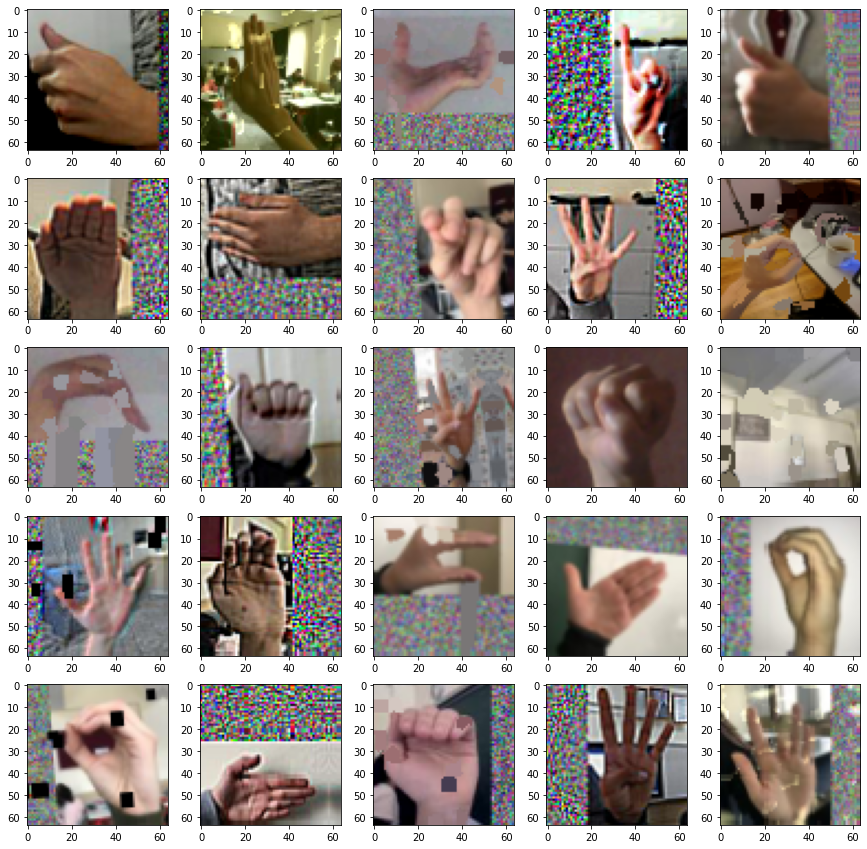

In [28]:
length = len(images['train'])
plt.figure(figsize=(15,15))
for j in range(1,26):
    img = synth(image=images['train'][rng.integers(0,length)])['image']
    plt.subplot(5,5,j), plt.imshow(img)

In [43]:
#images_length = images['train'].shape[0] 
images_length = len(images['train'])
synth_length = images_length

images_synth = np.zeros((synth_length, 64, 64, 3), dtype='uint8')
labels_synth = np.zeros((synth_length), dtype='uint8')
geom_img_synth = np.zeros((synth_length, 21,3), dtype='float32')
geom_wrl_synth = np.zeros((synth_length, 21,3), dtype='float32')
justnow = time()
for j in range(0, synth_length):
    random_draw = rng.integers(0,images_length)
    images_synth[j] = synth(image=images['train'][random_draw])['image']
    labels_synth[j] = sign_labels['train'][random_draw]
    geom_img_synth[j] = geom_img['train'][random_draw]
    geom_wrl_synth[j] = geom_wrl['train'][random_draw]
now = time()
print("Elapsed time", now-justnow, ", FPS", synth_length/(now-justnow))

Elapsed time 62.16362023353577 , FPS 415.9024185346978


In [54]:
np.save("datasets/train_img_64_synth.npy", images_synth)
np.save("datasets/train_lbl_synth.npy", labels_synth)
np.save("datasets/train_geom_img_synth.npy", geom_img_synth)
np.save("datasets/train_geom_wrl_synth.npy", geom_wrl_synth)

There's also a notion of test-time data augmentation: when the trained model is being evaluated, have it randomly generate some synthetic data of the type it's been trained on and see what it predicts for those as well. (Then it can take a vote or whatever.) Perhaps this could partly substitute for lack of sensorimotor variation in the static case. 

What tf does natively/dynamically: Contrast, Brightness, Crop, Flip, Height, Rotation, Translation, Width, Zoom; GaussianNoise

Some Albumentations methods not covered by the above: FancyPCA; CoarseDropout, Spatter, Superpixels; GridDistortion, OpticalDistortion; GlassBlur; Emboss, CLAHE, Sharpen; RandomGridShuffle

<h3>Image mixing</h3>

Examples of an unexpected data augmentation technique: mixing images by averaging their pixel values. Even more surprising, they say it can work even better if you mix images with different labels! (The label of the resulting superposition is randomly chosen from those of its components.)

In [588]:
img1 = cv.cvtColor(cv.imread("temp/A9.jpg"), cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(cv.imread("temp/A8.jpg"), cv.COLOR_BGR2RGB)

In [589]:
img1 = np.float32(img1)/255
img2 = np.float32(img2)/255

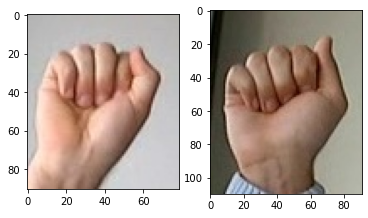

In [591]:
plt.subplot(1,2,1), plt.imshow(img1)
plt.subplot(1,2,2), plt.imshow(img2)
plt.show()

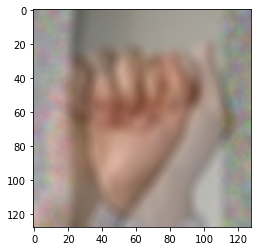

In [592]:
img3 = (square_and_rescale(img1, 128) +square_and_rescale(img2, 128))/2
plt.imshow(img3)
plt.show()

In [593]:
img1 = cv.imread('temp/11.png', flags=0)
img2 = cv.imread('temp/45.png', flags=0)

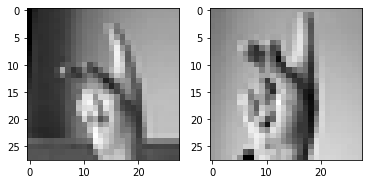

In [594]:
img1 = np.float32(img1)/255
img2 = np.float32(img2)/255
plt.subplot(1,2,1), plt.imshow(img1, 'gray')
plt.subplot(1,2,2), plt.imshow(img2, 'gray')
plt.show()

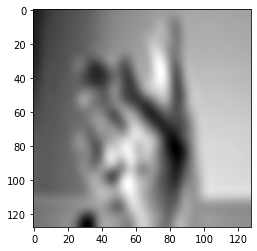

In [596]:
img3 = (square_and_rescale(img1, 128) +square_and_rescale(img2, 128))/2
plt.imshow(img3, 'gray')
plt.show()

<h2>ChicagoFSWild</h2>

The following scripts put the ChicagoFSWild dataset into ragged arrays/tensors suitable for use. For each frame up to 2 hands are taken and their respective bounding boxes are put into a list <i>images[key]</i> of length 2. At the same time the normalised hand landmark geometry data goes into <i>geom_img</i> and <i>geom_wrl</i>, and the TV-$L^1$ optical flow goes into <i>flow</i>. Everywhere something is not detected the lists are padded with zeros of the appropriate shape.

Each image list is schematically a ragged array with shape 

    [sequences, (frame_counts), (frame_heights), (frame_widths), channels], 

where the middle three axes are ragged in general (if the boxes are reshaped to squares only (frame_counts) is ragged). In order to store this efficiently it's saved as a flattened array. The data necessary to reconstruct the ragged array are the number_of_frames column in the ChicagoFSWild csv and the dimensions of each box. The auxiliary lists <i>corners</i> records where the cropped prism was in the original image, and the box dimensions can be computed from this. TensorFlow has a native RaggedTensor class which can do the reconstruction given this information the right way (as illustrated below).

If the frames are resized to 128x128, then (with RGB pixels of datatype uint8) each list of images will take just under 9.5gb of memory. If the frames are not resized the first image list should take about half as much space, and the second image list will take less, since the missing boxes are padded with single pixels of size 1x1.

In [329]:
hands_two = mp.solutions.hands.Hands(static_image_mode=False,
                                    max_num_hands=2,
                                    min_detection_confidence=0.4)

def get_hands_from_image(image, colour = 'rgb', pad_fraction = 0.2, pad_constant = 5):
    global hands_two
    if colour.lower() == 'bgr':
        results = hands_two.process(cv.cvtColor(image), cv.COLOR_BGR2RGB)
    else:
        results = hands_two.process(image)
    ret = 0
    if not results.multi_hand_landmarks:
        return (ret, [[(0,0),image.shape[0:2]]],[np.zeros((21,3))], [np.zeros((21,3))])
    marks_img = {} 
    marks_wrl = {}
    corners = {}
    for hand in range(len(results.multi_hand_landmarks)):
        # mp.Hands does left/right determination but it's not good enough
        #hand = results.multi_handedness[index].classification[0].label.lower()
        
        # mp.Hands generates two landmark sets, differing essentially in how they treat the depth of landmarks
        # the 'image position' estimates distance from the camera, I guess using some image proc methods
        # the 'world position' appears to estimate real-world angles, maybe using some ML method
        # MediaPipe internally calls the latter 'normalised landmarks' but the difference is not a simple transformation
        # in basic tests (like kNN), world marks performed slightly better
        marks = results.multi_hand_landmarks[hand].landmark
        corners[hand] = get_bounding_box_corners(marks._values, image.shape[0:2],
                                                 pad_fraction=pad_fraction, pad_constant=pad_constant)
        marks_img[hand] = np.zeros((21,3), dtype=np.float32)        
        copy_landmarks_to_array(marks, marks_img[hand])
        marks_img[hand] = normalise_hand_position(marks_img[hand])
        
        marks = results.multi_hand_world_landmarks[hand].landmark
        marks_wrl[hand] = np.zeros((21,3), dtype=np.float32)
        copy_landmarks_to_array(marks, marks_wrl[hand])
        marks_wrl[hand] = normalise_hand_position(marks_wrl[hand])
        ret += 1
    return (ret, corners, marks_img, marks_wrl)

def get_hands_from_file(filepath, **kwargs):
    image = cv.cvtColor(cv.flip(cv.imread(filepath), 1), cv.COLOR_BGR2RGB)
    return get_hands_from_image(image, **kwargs)

def visualise_flow(flow):
    hsv=np.zeros((flow.shape[0], flow.shape[1],3), dtype=np.float32)
    mag, ang = cv.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang*180/np.pi/2
    hsv[..., 2] = cv.normalize(mag, None, 0, 255, cv.NORM_MINMAX)
    rgb = cv.cvtColor(hsv, cv.COLOR_HSV2RGB)
    plt.imshow(rgb/255)
    return rgb

In [330]:
import pandas as pd
data_csv = pd.read_csv("ChicagoFSWild/ChicagoFSWild.csv", index_col=0)
#data_csv = pd.read_csv("h:/cfswp/ChicagoFSWildPlus.csv")
#data_csv.sample(5)
data_csv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7304 entries, 0 to 7303
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   filename          7304 non-null   object
 1   url               7304 non-null   object
 2   start_time        7304 non-null   object
 3   number_of_frames  7304 non-null   int64 
 4   width             7304 non-null   int64 
 5   height            7304 non-null   int64 
 6   label_proc        7304 non-null   object
 7   label_raw         7304 non-null   object
 8   label_notes       902 non-null    object
 9   partition         7304 non-null   object
 10  signer            7304 non-null   int64 
dtypes: int64(4), object(7)
memory usage: 684.8+ KB


In [331]:
splits = np.unique(data_csv['partition'])

base_in = "ChicagoFSWild/frames/"
base_out = "datasets/cfsw/"
#base_in = "h:/cfswp/frames/"
#base_out = "h:/cfswp/dataset/"

indices = {}

# cfswp
#indices['train'] =[0, 50400]
#indices['dev'] = [50400, 53515]
#indices['test'] = [53515, 55231]

# cfsw
indices['train'] = [0, 5455]
indices['dev'] = [5455, 6436]
indices['test'] = [6436, 7304]

In [332]:
# label information
#cfswp['label_proc'][22688] = ' '  # label is null and raises exceptions; fix it here or in the file
for key in splits:
    data_csv[['filename','label_proc','label_raw','number_of_frames']][indices[key][0]:indices[key][1]].to_csv(base_out + key + "_data.csv")

In [333]:
# encoding label_raw; note label_proc needs some pre-processing
alphabet = np.unique([char.lower() for seq in cfsw['label_proc'].apply(lambda x: [char for char in x]) for char in seq])
alphabet_ext = ['blank'] + list(alphabet) # blank character for ctc loss in position 0
encoder = {alphabet_ext[ind]:ind for ind in range(len(alphabet_ext))}
print(encoder)

{'blank': 0, ' ': 1, '&': 2, "'": 3, '.': 4, '@': 5, 'a': 6, 'b': 7, 'c': 8, 'd': 9, 'e': 10, 'f': 11, 'g': 12, 'h': 13, 'i': 14, 'j': 15, 'k': 16, 'l': 17, 'm': 18, 'n': 19, 'o': 20, 'p': 21, 'q': 22, 'r': 23, 's': 24, 't': 25, 'u': 26, 'v': 27, 'w': 28, 'x': 29, 'y': 30, 'z': 31}


In [55]:
# a subset of the characters that appear in the earlier set cfsw, so use the same encoder
np.unique([char.lower() for seq in cfswp['label_proc'].apply(lambda x: [char for char in x]) for char in seq])

array([' ', "'", 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k',
       'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x',
       'y', 'z'], dtype='<U1')

In [334]:
seq_lengths = {}
label_seqs = {}
label_proc = data_csv['label_proc'].convert_dtypes(infer_objects=False, convert_string=True, convert_integer=False, convert_boolean=False, convert_floating=False)
for key in splits:
    seq_lengths[key] = np.array(data_csv['label_proc'][indices[key][0]:indices[key][1]].apply(lambda x: len(x)), dtype=np.uint8)
    max_seq_length = max(seq_lengths[key])
    count = indices[key][1] - indices[key][0]
    label_seqs[key] = np.zeros((count, max_seq_length), dtype=np.uint8)
    print(label_seqs[key].shape)
    for j in range(count):
        for k in range(seq_lengths[key][j]):
            label_seqs[key][j][k] = encoder[data_csv['label_proc'][indices[key][0]+j][k].lower()]

(981, 29)
(868, 26)
(5455, 36)


In [335]:
print(label_seqs['train'][1000], data_csv['label_raw'][1000])

[10 26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0] eu


In [336]:
for key in splits:
    np.save(base_out + key + '_seq_lengths.npy', seq_lengths[key])
    np.save(base_out + key + '_label_seqs.npy', label_seqs[key])    

Mysteriously, mp.Hands sometimes returns more hands than it's told: despite being told <i>max_num_hands=2</i> (and this is the default value) in a very small number of frames (around 0.1% or so) it will return 3 hands! I can't locate why this happens; running the hands image processing by itself doesn't reproduce the bug (at least, not at the first place it happens for me in the script below). As a result this script will occasionally raise exceptions, but they are handled in general to keep the list padding correct (for this bug that's irrelevant, since it does record the data for the first two hands).

In [ ]:
# having 3d kernels means it's not enough to crop a hand out of each frame; there needs to be a prism the filters
# act on. one option is to remember the individual corners and pad each crop inside the prism over their join.
# simpler is just to take the prism over their join; and twice simpler if we want to compute optical flow as well

batch_size = 1000

tv = cv.optflow.DualTVL1OpticalFlow.create(0.16, 0.87, 0.005)
# for train split, sequence is skipped if too great a fraction is non-detects
skip_threshold=0.5

total_frames = 0
justnow = time()
warnings_list=[[],[]]

#images = {key: [[],[]] for key in splits}
#geom_img = {key: [[],[]] for key in splits}
#geom_wrl = {key: [[],[]] for key in splits}
#dims = {key: [[],[]] for key in splits}

for key in splits:
    batch_number = 0
    total_size = indices[key][1]-indices[key][0]
    while batch_number*batch_size <= total_size:
        # ready lists for the coming batch
        # two lists, one for hand A and one for hand B
        images = [[],[]]
        corners = [[],[]]
        flow=[[],[]]
        geom_img = [[],[]]
        geom_wrl = [[],[]]
        for j in range(indices[key][0]+batch_number*batch_size, indices[key][0]+(batch_number+1)*batch_size):
            if j >= indices[key][1]:
                break
            # for mp.Hands we use static_mode off (it's faster and catches some frames that get missed in static mode)
            #  so, mp.Hands must be told that this is the start of a new frame sequence
            hands_two.reset()
            # maintain lists local to this sequence
            # seq will be skipped if exception occurs, or it's in train split and too many nondetects occur
            nondetect = 0
            excepted = False
            images_local=[[],[]]
            corners_local=[0,0]
            crnrs_list=[[],[]]
            flow_local=[[],[]]
            geom_img_local=[[],[]]
            geom_wrl_local=[[],[]]
            
            directory = base_in + data_csv['filename'][j] + "/"
            frame_count = data_csv['number_of_frames'][j]
            seq = np.zeros((frame_count, data_csv['height'][j], data_csv['width'][j], 3), dtype=np.uint8)
            print(j, data_csv['filename'][j], frame_count)
            
            # load the files and run the hand detector on them
            for k in range(1, frame_count+1):
                # filenames are 4 characters, the frame number padded with zeros on the left
                if k >= 100:
                    filepath = directory + "0"+str(k)+".jpg"
                elif k >= 10:
                    filepath = directory + "00"+str(k)+".jpg"
                else:
                    filepath = directory + "000"+str(k)+".jpg"
                seq[k-1] = cv.cvtColor(cv.imread(filepath), cv.COLOR_BGR2RGB)
                ret, crnrs, marks_img, marks_wrl = get_hands_from_image(seq[k-1], pad_constant=10)
                ret = min(ret, 2)
                if ret == 0:
                    warnings_list[0].append(filepath)
                    nondetect += 1
                for hand in range(ret):
                    crnrs_list[hand].append(crnrs[hand])
                    geom_img_local[hand].append(marks_img[hand])
                    geom_wrl_local[hand].append(marks_wrl[hand])
                for hand in range(ret, 2):
                    # pad the lists that need padding
                    geom_img_local[hand].append(np.zeros((21,3), dtype=np.float32))
                    geom_wrl_local[hand].append(np.zeros((21,3), dtype=np.float32))
            for hand in range(2):
                # find the prism join of the hand bounding boxes, add it to images_local, and compute the flow
                try:
                    if len(crnrs_list[hand]) > 0:
                        corners_local[hand] = get_rectangle_join_corners(crnrs_list[hand])
                        images_local[hand] = get_prism_join([corners_local[hand]], seq)
                        flow_temp = []
                        for k in range(frame_count-1):
                            flow_temp.append(tv.calc(cv.cvtColor(images_local[hand][k], cv.COLOR_RGB2GRAY), 
                                                     cv.cvtColor(images_local[hand][k+1], cv.COLOR_RGB2GRAY),
                                                     None).reshape(-1,2))
                        flow_local[hand] = np.float16(np.concatenate(flow_temp, axis=0))
                    else:
                        corners_local[hand] = [(0,0),(1,1)]
                        images_local[hand] = np.zeros((frame_count, 1, 1, 3), dtype=np.uint8)
                        flow_local[hand] = np.zeros((frame_count-1, 1, 1, 2), dtype=np.float16)
                except:
                    excepted = True
                    warnings_list[1].append(j)
            total_frames += frame_count
                                                    
            if excepted or (key == 'train' and nondetect > frame_count*skip_threshold):
                print("Skipping " + data_csv['partition'][j] + "/" + data_csv['filename'][j] + 
                      ", lost frames = " +str(nondetect) + "/" + str(frame_count)+
                      ", exc = " + str(excepted))
            else:
                for hand in range(2):
                    images[hand].append(images_local[hand].reshape(-1,3))
                    flow[hand].append(flow_local[hand])
                    corners[hand].append(corners_local[hand])
                    geom_img[hand].append(np.concatenate(geom_img_local[hand], axis=0))
                    geom_wrl[hand].append(np.concatenate(geom_wrl_local[hand], axis=0))
        # save batch to file
        batch_suffix = "_" + str(batch_number) + ".npy"
        # ragged arrays flattened to array of pixel channels
        np.save(base_out+key+"_img_a"+batch_suffix, np.concatenate(images[0], axis=0))
        np.save(base_out+key+"_img_b"+batch_suffix, np.concatenate(images[1], axis=0))
        np.save(base_out+key+"_flow_a"+batch_suffix, np.concatenate(flow[0], axis=0))
        np.save(base_out+key+"_flow_b"+batch_suffix, np.concatenate(flow[1], axis=0))
        np.save(base_out+key+"_geom_img_a"+batch_suffix, np.concatenate(geom_img[0], axis=0))
        np.save(base_out+key+"_geom_img_b"+batch_suffix, np.concatenate(geom_img[1], axis=0))
        np.save(base_out+key+"_geom_wrl_a"+batch_suffix, np.concatenate(geom_wrl[0], axis=0))
        np.save(base_out+key+"_geom_wrl_b"+batch_suffix, np.concatenate(geom_wrl[1], axis=0))
        np.save(base_out+key+"_corners"+batch_suffix, corners)
        batch_number += 1
now = time()
print("Elapsed time", now-justnow, "FPS", total_frames/(now-justnow), "lost fraction", len(warnings_list[0])/total_frames)

5455 aslized/joy_maisel_6419 66
5456 aslized/joy_maisel_6420 35
5457 aslized/joy_maisel_6421 17
5458 aslized/joy_maisel_6422 14
5459 aslized/joy_maisel_6423 40
5460 aslized/joy_maisel_6424 29
5461 aslized/joy_maisel_6425 11
5462 aslized/joy_maisel_6426 38
5463 aslized/joy_maisel_6427 54
5464 aslized/joy_maisel_6428 47
5465 aslized/joy_maisel_6429 38
5466 aslized/joy_maisel_6430 33
5467 aslized/joy_maisel_6431 37
5468 aslized/joy_maisel_6432 33
5469 aslized/joy_maisel_6433 14
5470 aslized/joy_maisel_6434 71
5471 aslized/joy_maisel_6435 25
5472 aslized/joy_maisel_6436 30
5473 aslized/joy_maisel_6437 9
5474 aslized/joy_maisel_6438 41
5475 aslized/joy_maisel_6439 24
5476 aslized/joy_maisel_6440 33
5477 aslized/joy_maisel_6441 12
5478 aslized/joy_maisel_6442 36
5479 aslized/joy_maisel_6443 24
5480 aslized/joy_maisel_6444 22
5481 aslized/joy_maisel_6445 8
5482 aslized/joy_maisel_6446 24
5483 aslized/suzanne_stecker_0194 70
5484 aslized/suzanne_stecker_0195 33
5485 aslized/suzanne_stecker_019

In [339]:
warnings_list

[[], []]

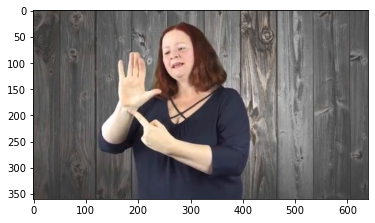

In [341]:
plt.imshow(image)

In [261]:
print(210-56, 264-143)

154 121


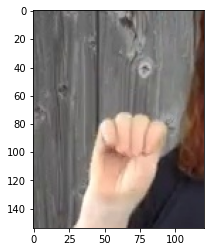

In [308]:
j=30
plt.imshow(images[0][0][j*154*121:(j+1)*154*121].reshape(210-56,264-143,3))

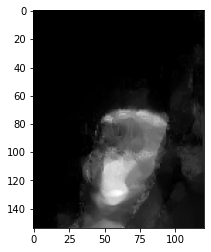

In [307]:
j=30
rgb = visualise_flow(np.float32(flow[0][0][j*154*121:(j+1)*154*121].reshape(154,121,2)))/255
# sometimes round-off error will produce values slightly outside [0,1] here, giving a clipping warning

In [50]:
# frames with no hand detected
for filename in warnings_list[0]:
    img = cv.imread(filename)
    filepath = Path(filename)
    outname = "temp/" + filepath.parts[-2] + "_" + filepath.parts[-1] + filepath.suffix
    cv.imwrite(outname, img)

<b>Reconstruction</b> as a ragged tensor dataset is illustrated below.

In [34]:
import tensorflow as tf

In [81]:
seqs = 5
frame_counts = cfsw['number_of_frames'][0:seqs]
total_frames = frame_counts.sum()
small_img_set = images['train'][0][0:total_frames]
flat_img_set = np.array(list(chain(*chain.from_iterable(small_img_set))))
flat_img_set.shape

(1999908, 3)

In [77]:
# change this to get height/width from the corners data
frame_heights = [dim[0] for dim in dims['train'][0][0:total_frames]]
frame_widths = [dim[1] for dim in dims['train'][0][0:total_frames]]
temp = [[frame_widths[j]]*frame_heights[j] for j in range(total_frames)]
by_widths = list(chain.from_iterable(temp))

In [83]:
reconstruct = tf.RaggedTensor.from_row_lengths(tf.RaggedTensor.from_row_lengths(tf.RaggedTensor.from_row_lengths(flat_img_set, 
                                                                                                                 by_widths),
                                                                                  frame_heights),
                                                  frame_counts)
reconstruct.get_shape()

TensorShape([5, None, None, None, 3])

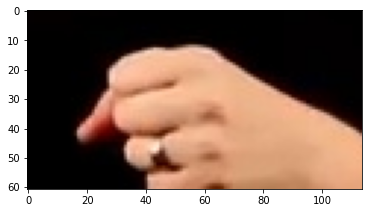

In [84]:
plt.imshow(reconstruct.to_list()[0][0])

In [85]:
reconstructed_data = tf.data.Dataset.from_tensor_slices(reconstruct)
sample_tensor = reconstructed_data.take(1)
sample_set = [seq for seq in sample_tensor]

(61, None, 3)
(114, 3)


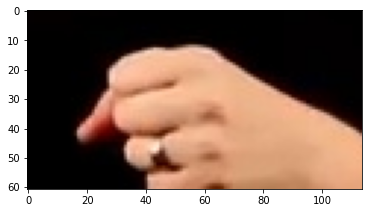

In [86]:
print(sample_set[0][0].get_shape())
print(sample_set[0][0][0].get_shape())
plt.imshow(sample_set[0][0].numpy())

Scratchwork from the surplus hands bug; ignore this.

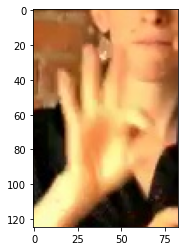

In [83]:
# the frames grabbed at the first exception
plt.imshow(globalthing[0])

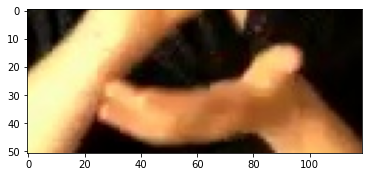

In [84]:
plt.imshow(globalthing[1])

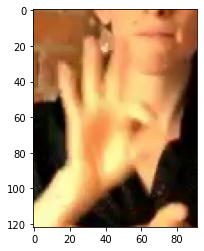

In [85]:
plt.imshow(globalthing[2])

In [87]:
globalthing[0] - globalthing[2]

ValueError: operands could not be broadcast together with shapes (125,83,3) (122,92,3) 

In [98]:
# I could not reproduce this bug by just processing through the frames up to that point
for j in range(1,10):
    hands_two.reset()
    for frame in Path("ChicagoFSWild/frames/aslized/elsie_stecker_000"+str(j)).iterdir():
        img = cv.cvtColor(cv.imread(str(frame)), cv.COLOR_BGR2RGB)
for j in range(10,34):
    hands_two.reset()
    for frame in Path("ChicagoFSWild/frames/aslized/elsie_stecker_00"+str(j)).iterdir():
        img = cv.cvtColor(cv.imread(str(frame)), cv.COLOR_BGR2RGB)
        
hands_two.reset()
img = cv.cvtColor(cv.imread("ChicagoFSWild/frames/aslized/elsie_stecker_0034/0001.jpg"), cv.COLOR_BGR2RGB)
hands_two.process(img)
img = cv.cvtColor(cv.imread("ChicagoFSWild/frames/aslized/elsie_stecker_0034/0002.jpg"), cv.COLOR_BGR2RGB)
hands_two.process(img)
img = cv.cvtColor(cv.imread("ChicagoFSWild/frames/aslized/elsie_stecker_0034/0003.jpg"), cv.COLOR_BGR2RGB)
hands_two.process(img)
img = cv.cvtColor(cv.imread("ChicagoFSWild/frames/aslized/elsie_stecker_0034/0004.jpg"), cv.COLOR_BGR2RGB)
results = hands_two.process(img)
print(len(results.multi_hand_landmarks))

2


In [ ]:
# old code, ignore this

batch_size = 500

tv = cv.optflow.DualTVL1OpticalFlow.create(0.23, 0.1, 0.03)
frame_size = 128
resize = False # this being on may cause problems with padded hand frames and finding flow
use_last_on_nondetect = True
keep_on_nondetect = True
# for train split, sequence is skipped if too great a fraction is non-detects
skip_threshold=0.5

total_frames = 0
justnow = time()
warnings_list=[[],[]]

#images = {key: [[],[]] for key in splits}
#geom_img = {key: [[],[]] for key in splits}
#geom_wrl = {key: [[],[]] for key in splits}
#dims = {key: [[],[]] for key in splits}

for key in splits:
    batch_number = 0
    total_size = indices[key][1]-indices[key][0]
    while batch_number*batch_size <= total_size:
        # ready lists for the coming batch
        # two lists, one for hand A and one for hand B
        images = [[],[]]
        corners = [[],[]]
        flow=[[],[]]
        flow_corners=[[],[]]
        geom_img = [[],[]]
        geom_wrl = [[],[]]
        for j in range(indices[key][0]+batch_number*batch_size, indices[key][0]+(batch_number+1)*batch_size):
            if j >= indices[key][1]:
                break
            # for mp.Hands we use static_mode off (it's faster and catches some frames that get missed in static mode)
            #  so, mp.Hands must be told that this is the start of a new frame sequence
            hands_two.reset()
            # maintain lists local to this sequence
            # seq will be skipped if exception occurs, or it's in train split and too many nondetects occur
            last_frame=0
            excepted = False
            images_local=[[],[]]
            corners_local=[[],[]]
            flow_local=[[],[]]
            flow_corners_local=[[],[]]
            geom_img_local=[[],[]]
            geom_wrl_local=[[],[]]
            directory = base_in + data_csv['filename'][j] + "/"
            frame_count = data_csv['number_of_frames'][j]
            print(j, data_csv['filename'][j], frame_count)
            
            for k in range(1, frame_count+1):
                # filenames are 4 characters, the frame number padded with zeros on the left
                if k >= 100:
                    filepath = directory + "0"+str(k)+".jpg"
                elif k >= 10:
                    filepath = directory + "00"+str(k)+".jpg"
                else:
                    filepath = directory + "000"+str(k)+".jpg"
                image = cv.cvtColor(cv.imread(filepath), cv.COLOR_BGR2RGB)
                ret, boxes, crnrs, marks_img, marks_wrl = get_hands_from_image(image, pad_constant=10)
                
                if ret == 0:
                    warnings_list[0].append(filepath)
                    if use_last_on_nondetect and k >= 2:
                        ret = 1
                        crnrs[0] = corners_local[0][-1]
                        boxes[0] = get_rectangle(crnrs[0], image)
                    elif keep_on_nondetect:
                        ret = 1
                        boxes[0] = square_and_rescale(boxes[0], frame_size)
                pad_range=range(ret, 2)
                for hand in range(ret):
                    if hand >= 2:
                        continue
                    try:
                        if resize:
                            boxes[hand] = square_and_rescale(boxes[hand], frame_size)
                        # so images is a flattened list of RGB pixels
                        images_local[hand].append(boxes[hand].reshape(-1,3))
                        if k >= 2:
                            # if there was a nondetection now or last frame we calculate flow on the intersection
                            if corners_local[hand][-1] == [(0,0), last_frame.shape[0:2]] or crnrs[hand] == [(0,0), image.shape[0:2]]:
                                    flow_crnrs = get_rectangle_meet_corners([crnrs[hand], corners_local[hand][-1]])
                            # otherwise, calculate flow on the join of the bounding boxes        
                            else:
                                flow_crnrs = get_rectangle_join_corners([crnrs[hand], corners_local[hand][-1]])                      
                            
                            flow_local[hand].append(tv.calc(cv.cvtColor(get_rectangle(flow_crnrs, last_frame), 
                                                                        cv.COLOR_RGB2GRAY),
                                                            cv.cvtColor(get_rectangle(flow_crnrs, image), 
                                                                        cv.COLOR_RGB2GRAY),
                                                           None).reshape(-1,2))
                            flow_corners_local[hand].append(flow_crnrs)
                        corners_local[hand].append(crnrs[hand])
                        geom_img_local[hand].append(marks_img[hand])
                        geom_wrl_local[hand].append(marks_wrl[hand])

                    except:
                        print("Exc:", filepath, hand, ret)
                        #pad_range=range(hand, 2)
                        excepted=True
                        warnings_list[1].append(filepath)
                for hand in pad_range:
                    pad_size = 1
                    if resize:
                        pad_size = frame_size
                    images_local[hand].append([np.zeros((pad_size*pad_size*3), dtype=np.uint8)])
                    if k >= 2:
                        flow_local[hand].append([np.zeros((pad_size*pad_size*2), dtype=np.float32)])
                        flow_corners_local[hand].append([(0,0), (pad_size, pad_size)])
                    corners_local[hand].append([(0,0), (pad_size, pad_size)])
                    geom_img_local[hand].append(np.zeros((21,3), dtype=np.float32))
                    geom_wrl_local[hand].append(np.zeros((21,3), dtype=np.float32))
                total_frames += 1
                last_frame = image
                                                    
            if excepted or (key == 'train' and nondetect_local >= frame_count*skip_threshold):
                print("Skipping " + data_csv['partition'][j] + "/" + data_csv['filename'][j] + 
                      ", lost frames = " +str(nondetect_local) + "/" + str(frame_count)+
                      ", exc = " + str(excepted))
            else:
                for hand in range(2):
                    images[hand].append(np.concatenate(images_local[hand], axis=0))
                    flow[hand].append(np.concatenate(flow_local[hand], axis=0))
                    corners[hand].append(corners_local[hand])
                    flow_corners[hand].append(flow_corners_local[hand])
                    geom_img[hand].append(geom_img_local[hand])
                    geom_wrl[hand].append(geom_wrl_local[hand])
        # save batch to file
        batch_suffix = "_" + str(batch_number) + ".npy"
        # ragged arrays flattened to array of pixel channels
        np.save(base_out+key+"_img_a"+batch_suffix, np.concatenate(images[0], axis=0))
        np.save(base_out+key+"_img_b"+batch_suffix, np.concatenate(images[1], axis=0))
        np.save(base_out+key+"_flow_a"+batch_suffix, np.concatenate(flow[0], axis=0))
        np.save(base_out+key+"_flow_b"+batch_suffix, np.concatenate(flow[1], axis=0))
        # fixed-size arrays indexed by sequence number
        np.save(base_out+key+"_corners_a"+batch_suffix, corners[0])
        np.save(base_out+key+"_corners_b"+batch_suffix, corners[1])
        np.save(base_out+key+"_flow_corners_a"+batch_suffix, flow_corners[0])
        np.save(base_out+key+"_flow_corners_b"+batch_suffix, flow_corners[1])
        np.save(base_out+key+"_geom_img_a"+batch_suffix, geom_img[0])
        np.save(base_out+key+"_geom_img_b"+batch_suffix, geom_img[1])
        np.save(base_out+key+"_geom_wrl_a"+batch_suffix, geom_wrl[0])
        np.save(base_out+key+"_geom_wrl_b"+batch_suffix, geom_wrl[1])
        batch_number += 1
now = time()
print("Elapsed time", now-justnow, "FPS", total_frames/(now-justnow), "lost fraction", len(warnings_list[0])/total_frames)